
## In situ data and trajectories incl. Bepi Colombo, PSP, Solar Orbiter
https://github.com/cmoestl/heliocats

Author: C. Möstl, Austrian Space Weather Office, Geosphere Austria, https://helioforecast.space

twitter @chrisoutofspace, https://mastodon.social/@chrisoutofspace, https://github.com/cmoestl

last update: 2022 November 25

needs python 3.7 with the conda helio environment (see README.md)

uses heliopy for generating spacecraft positions, for data source files see README.md
    


In [3]:
#change path for ffmpeg for animation production if needed

ffmpeg_path=''

import os
import datetime
from datetime import datetime, timedelta
from sunpy.time import parse_time
import sunpy
import astropy.units as u
from concurrent.futures import ThreadPoolExecutor
from functools import partial
import itertools

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import spiceypy
import pandas as pd
from joblib import Parallel, delayed

import matplotlib.cm as cmap
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from scipy.signal import medfilt
import numpy as np
import pdb
import pickle
import seaborn as sns
import sys
import heliopy.data.spice as spicedata
import heliopy.spice as spice
import astropy
import importlib    
import time
import numba
from numba import jit
import multiprocessing
import multiprocess as mp
import urllib
import copy
from astropy import constants as const
import astrospice

import warnings
warnings.filterwarnings('ignore')

from heliocats import data as hd
importlib.reload(hd) #reload again while debugging

from heliocats import plot as hp
importlib.reload(hp) #reload again while debugging

#where the in situ data files are located is read 
#from config_server.py 
#from config_server import data_path

data_path = 'data/'

print('done')

done


## generate DONKI kinematics (using elevo) & arrival times/speeds

In [27]:
print('load positions')   

#positions needed for arrival time/speed calculation and plotting below
[psp, solo, sta, stereob_recon, bepi, wind, earth, mercury, venus, mars, jupiter, saturn, uranus, neptune]=pickle.load( open( data_path+'positions_psp_solo_sta_bepi_wind_planets_HEEQ_1hour_rad.p', "rb" ) )

print('done')

load positions
done


In [98]:
#remove text-file with arrival time/speed
os.remove('ICME_arrival.txt') #besser wäre es, das file in einen anderen Ordner zu verschieben

In [95]:
date=(datetime.now()-timedelta(days=10)).strftime('%Y-%m-%d')

url_donki='https://kauai.ccmc.gsfc.nasa.gov/DONKI/WS/get/CMEAnalysis?startDate='+date+'&mostAccurateOnly=true'
try: urllib.request.urlretrieve(url_donki,'data/DONKI.json')
except urllib.error.URLError as e:
    print('DONKI not loaded')
    
data = pd.read_json('data/DONKI.json')

print('# CMEs within last 10 days: ', len(data))
print('done')

# CMEs within last 10 days:  23
done


In [96]:
def donki_kinematics(i):
    print(f'Processing CME {i+1}')
    
    r21_t0 = data.time21_5
    distance0 = 21.5*u.solRad.to(u.km)
    t0 = pd.to_datetime(r21_t0)
    t0_num = mdates.date2num(data.time21_5)
    gamma_init = 0.15
    ambient_wind_init = 450.
    kindays = 20
    n_ensemble = 50000
    halfwidth = np.deg2rad(55.)
    res_in_min = 10
    f = 0.7

    dct = t0_num[i]-earth.time
    earth_ind = np.argmin(np.abs(dct))

    if np.abs(np.deg2rad(data.longitude[i])) + np.abs(earth.lon[earth_ind]) < np.pi:
        delta_earth = np.deg2rad(data.longitude[i]) - earth.lon[earth_ind]
    else:
        delta_earth = np.deg2rad(data.longitude[i]) - (earth.lon[earth_ind] + 2 * np.pi * np.sign(np.deg2rad(data.longitude[i])))

    #times for each event kinematic
    time1=[]
    tstart1=copy.deepcopy(t0[i])
    tend1=tstart1+timedelta(days=kindays)
    #make 30 min datetimes
    while tstart1 < tend1:

        time1.append(tstart1)  
        tstart1 += timedelta(minutes=res_in_min)    

    #make kinematics
    
    kindays_in_min = int(kindays*24*60/res_in_min)
    
    timestep=np.zeros([kindays_in_min,n_ensemble])
    cme_r=np.zeros([kindays_in_min, 3])
    cme_lon=np.ones(kindays_in_min)*data.longitude[i]
    cme_lat=np.ones(kindays_in_min)*data.latitude[i]
    cme_id=np.chararray(kindays_in_min, itemsize=27)
    cme_r_ensemble=np.zeros([kindays_in_min, n_ensemble])
    cme_delta=delta_earth*np.ones([kindays_in_min,3])
    cme_hit=np.zeros(kindays_in_min)
    cme_hit[np.abs(delta_earth)<np.deg2rad(55.)] = 1
    distance_earth = np.empty([kindays_in_min,3])
    distance_earth[:] = np.nan
    
    for j in np.arange(0,len(cme_r)-1,1):

        cme_id[0]=data.associatedCMEID[i]
        cme_id[j+1]=data.associatedCMEID[i]
        cme_r[0]=distance0*u.km.to(u.au)

        timestep[j+1]=timestep[j]+res_in_min*60 #seconds (speed given in kilometers per second)

        gamma = np.random.normal(gamma_init,0.025,n_ensemble)
        ambient_wind = np.random.normal(ambient_wind_init,50,n_ensemble)
        speed = np.random.normal(data.speed[i],50,n_ensemble)

        accsign = np.ones(n_ensemble)
        accsign[speed < ambient_wind] = -1.

        distance0_list = np.array(distance0*np.ones(n_ensemble))
        
        #calculate radial distance for each timestep, CME, and ensemble member
        cme_r_ensemble[j+1]=(accsign / (gamma * 1e-7)) * np.log(1 + (accsign * (gamma * 1e-7) * ((speed - ambient_wind) * timestep[j+1]))) + ambient_wind * timestep[j+1] + distance0_list
        
        cme_r[j+1][0]=np.mean(cme_r_ensemble[j+1])*u.km.to(u.au)
        cme_r[j+1][1]=np.mean(cme_r_ensemble[j+1])*u.km.to(u.au) - 2*np.std(cme_r_ensemble[j+1])*u.km.to(u.au)
        cme_r[j+1][2]=np.mean(cme_r_ensemble[j+1])*u.km.to(u.au) + 2*np.std(cme_r_ensemble[j+1])*u.km.to(u.au)
    
    #Ellipse parameters   
    theta = np.arctan(f**2*np.ones([kindays_in_min,3]) * np.tan(halfwidth*np.ones([kindays_in_min,3])))
    omega = np.sqrt(np.cos(theta)**2 * (f**2*np.ones([kindays_in_min,3]) - 1) + 1)   
    cme_b = cme_r * omega * np.sin(halfwidth*np.ones([kindays_in_min,3])) / (np.cos(halfwidth*np.ones([kindays_in_min,3]) - theta) + omega * np.sin(halfwidth*np.ones([kindays_in_min,3])))    
    cme_a = cme_b / f*np.ones([kindays_in_min,3])
    cme_c = cme_r - cme_b
        
    root = np.sin(cme_delta)**2 * f**2*np.ones([kindays_in_min,3]) * (cme_b**2 - cme_c**2) + np.cos(cme_delta)**2 * cme_b**2
    distance_earth[cme_hit.all() == 1] = (cme_c * np.cos(cme_delta) + np.sqrt(root)) / (np.sin(cme_delta)**2 * f**2*np.ones([kindays_in_min,3]) + np.cos(cme_delta)**2) #distance from SUN in AU for given point on ellipse

    arr_time = []
    arr_speed = []
    arrival = []
    if np.isnan(distance_earth).all() == False:
        
        for t in range(3):
            index = np.argmin(np.abs(distance_earth[:,t] - earth.r[earth_ind]))
            distance_diff = np.diff(distance_earth[:,t]*u.au.to(u.km))
            time_diff = np.diff(timestep[:,i])
            speed = distance_diff / time_diff
            arr_time.append(time1[int(index)])
            arr_speed.append(speed[int(index-1)])
            
        err_arr_time = (arr_time[1]-arr_time[2]).total_seconds()/3600.   
        arrival.append([cme_id[i], cme_lat[i], cme_lon[i], r21_t0[i], arr_time[0], np.round(err_arr_time,2), arr_speed[0]])    
            
    #### linear interpolate to 10 min resolution

    #find next full hour after t0
    format_str = '%Y-%m-%d %H'  
    t0r = datetime.strptime(datetime.strftime(t0[i], format_str), format_str) +timedelta(hours=1)
    time2=[]
    tstart2=copy.deepcopy(t0r)
    tend2=tstart2+timedelta(days=kindays)
    #make 30 min datetimes 
    while tstart2 < tend2:
        time2.append(tstart2)  
        tstart2 += timedelta(minutes=res_in_min)  

    time2_num=parse_time(time2).plot_date        
    time1_num=parse_time(time1).plot_date

    #linear interpolation to time_mat times    
    cme_r = [np.interp(time2_num, time1_num,cme_r[:,i]) for i in range(3)]
    cme_lat = np.interp(time2_num, time1_num,cme_lat )
    cme_lon = np.interp(time2_num, time1_num,cme_lon )
    cme_a = [np.interp(time2_num, time1_num,cme_a[:,i]) for i in range(3)]
    cme_b = [np.interp(time2_num, time1_num,cme_b[:,i]) for i in range(3)]
    cme_c = [np.interp(time2_num, time1_num,cme_c[:,i]) for i in range(3)]
    
    with open("ICME_arrival.txt", "ab") as f:
        np.savetxt(f, arrival, newline='\n', fmt='%s')
    
    return time2_num, cme_r, cme_lat, cme_lon, cme_a, cme_b, cme_c, cme_id

print('done')

done


In [97]:
print('generate kinematics using elevo and multiprocessing')

start_time = time.time()

used=6
print('Using multiprocessing, nr of cores',mp.cpu_count(), ', nr of processes used: ',used)
pool=mp.get_context('fork').Pool(processes=used)

results = pool.map(donki_kinematics, range(len(data)))

pool.close()
pool.join() 

print('time in seconds: ',np.round((time.time()-start_time)))

generate kinematics using elevo and multiprocessing
Using multiprocessing, nr of cores 8 , nr of processes used:  6
Processing CME 1Processing CME 2Processing CME 3
Processing CME 4
Processing CME 5Processing CME 6



Processing CME 7
Processing CME 8
Processing CME 9
Processing CME 10
Processing CME 11
Processing CME 12
Processing CME 13
Processing CME 14
Processing CME 15
Processing CME 16
Processing CME 17
Processing CME 18
Processing CME 19
Processing CME 20
Processing CME 21
Processing CME 22
Processing CME 23
time in seconds:  39.0


In [74]:
hc_time_num1 = [result[0] for result in results]
hc_time_num1 = np.concatenate(hc_time_num1)

hc_r1 = [result[1] for result in results]
hc_r1 = np.concatenate(hc_r1, axis=1)

hc_lat1 = [result[2] for result in results]
hc_lat1 = np.concatenate(hc_lat1)

hc_lon1 = [result[3] for result in results]
hc_lon1 = np.concatenate(hc_lon1)

a_ell = [result[4] for result in results]
a1_ell = np.concatenate(a_ell, axis=1)

b_ell = [result[5] for result in results]
b1_ell = np.concatenate(b_ell, axis=1)

c_ell = [result[6] for result in results]
c1_ell = np.concatenate(c_ell, axis=1)

hc_id = [result[7] for result in results]
hc_id1 = np.concatenate(hc_id)

pickle.dump([hc_time_num1, hc_r1, hc_lat1, hc_lon1, hc_id1, a1_ell, b1_ell, c1_ell], open('data/donki_kinematics.p', "wb"))

In [75]:
[hc_time_num1, hc_r1, hc_lat1, hc_lon1, hc_name1, a1_ell, b1_ell, c1_ell]=pickle.load(open('data/donki_kinematics.p', "rb"))

### define functions

In [34]:
def make_frame(k):
    '''
    loop each frame in multiprocessing
    '''
    

    fig=plt.figure(1, figsize=(19.2,10.8), dpi=100) #full hd
    #fig=plt.figure(1, figsize=(19.2*2,10.8*2), dpi=100) #4k
    ax = plt.subplot2grid((3,2), (0, 0), rowspan=3, projection='polar')
    backcolor='black'
    psp_color='black'
    bepi_color='blue'
    solo_color='coral'


    frame_time_str=str(mdates.num2date(frame_time_num+k*res_in_days))
   
    #these have their own times
    
    dct=frame_time_num+k*res_in_days-psp.time
    psp_timeind=np.argmin(abs(dct))

    dct=frame_time_num+k*res_in_days-bepi.time 
    bepi_timeind=np.argmin(abs(dct))

    dct=frame_time_num+k*res_in_days-solo.time
    solo_timeind=np.argmin(abs(dct))
    
    dct=frame_time_num+k*res_in_days-sta.time
    sta_timeind=np.argmin(abs(dct))

    #all same times
    dct=frame_time_num+k*res_in_days-earth.time
    earth_timeind=np.argmin(abs(dct))

    #plot all positions including text R lon lat for some 

    #white background

    ax.scatter(venus.lon[earth_timeind], venus.r[earth_timeind]*np.cos(venus.lat[earth_timeind]), s=symsize_planet, c='tab:purple', alpha=1,lw=0,zorder=3)
    ax.scatter(mercury.lon[earth_timeind], mercury.r[earth_timeind]*np.cos(mercury.lat[earth_timeind]), s=symsize_planet, c='dimgrey', alpha=1,lw=0,zorder=3)
    ax.scatter(earth.lon[earth_timeind], earth.r[earth_timeind]*np.cos(earth.lat[earth_timeind]), s=symsize_planet, c='mediumseagreen', alpha=1,lw=0,zorder=3)
    ax.scatter(sta.lon[sta_timeind], sta.r[sta_timeind]*np.cos(sta.lat[sta_timeind]), s=symsize_spacecraft, c='red', marker='s', alpha=1,lw=0,zorder=3)
    ax.scatter(mars.lon[earth_timeind], mars.r[earth_timeind]*np.cos(mars.lat[earth_timeind]), s=symsize_planet, c='orangered', alpha=0.7,lw=0,zorder=3)




    #plot stereoa fov hi1/2    
    hp.plot_stereo_hi_fov(sta,frame_time_num, sta_timeind, ax,'A')



    #positions text
    f10=plt.figtext(0.01,0.93,'              R     lon     lat', fontsize=fsize+2, ha='left',color=backcolor)

    if frame=='HEEQ': earth_text='Earth: '+str(f'{earth.r[earth_timeind]:6.2f}')+str(f'{0.0:8.1f}')+str(f'{np.rad2deg(earth.lat[earth_timeind]):8.1f}')
    else: earth_text='Earth: '+str(f'{earth.r[earth_timeind]:6.2f}')+str(f'{np.rad2deg(earth.lon[earth_timeind]):8.1f}')+str(f'{np.rad2deg(earth.lat[earth_timeind]):8.1f}')

    mars_text='Mars:  '+str(f'{mars.r[earth_timeind]:6.2f}')+str(f'{np.rad2deg(mars.lon[earth_timeind]):8.1f}')+str(f'{np.rad2deg(mars.lat[earth_timeind]):8.1f}')
    sta_text='STA:   '+str(f'{sta.r[sta_timeind]:6.2f}')+str(f'{np.rad2deg(sta.lon[sta_timeind]):8.1f}')+str(f'{np.rad2deg(sta.lat[sta_timeind]):8.1f}')

    #position and text 
    if psp_timeind > 0:
        #plot trajectorie
        ax.scatter(psp.lon[psp_timeind], psp.r[psp_timeind]*np.cos(psp.lat[psp_timeind]), s=symsize_spacecraft, c=psp_color, marker='s', linestyle='--', alpha=1,lw=0,zorder=3)
        #plot positiona as text
        psp_text='PSP:   '+str(f'{psp.r[psp_timeind]:6.2f}')+str(f'{np.rad2deg(psp.lon[psp_timeind]):8.1f}')+str(f'{np.rad2deg(psp.lat[psp_timeind]):8.1f}')
        f5=plt.figtext(0.01,0.78,psp_text, fontsize=fsize, ha='left',color=psp_color)
        if plot_orbit: 
            fadestart=psp_timeind-fadeind
            if  fadestart < 0: fadestart=0
            ax.plot(psp.lon[fadestart:psp_timeind+fadeind], psp.r[fadestart:psp_timeind+fadeind]*np.cos(psp.lat[fadestart:psp_timeind+fadeind]), c=psp_color, linestyle='--', alpha=0.6,lw=1,zorder=3)
    
    if bepi_timeind > 0:
        ax.scatter(bepi.lon[bepi_timeind], bepi.r[bepi_timeind]*np.cos(bepi.lat[bepi_timeind]), s=symsize_spacecraft, c=bepi_color, marker='s', alpha=1,lw=0,zorder=3)
        bepi_text='Bepi:   '+str(f'{bepi.r[bepi_timeind]:6.2f}')+str(f'{np.rad2deg(bepi.lon[bepi_timeind]):8.1f}')+str(f'{np.rad2deg(bepi.lat[bepi_timeind]):8.1f}')
        f6=plt.figtext(0.01,0.74,bepi_text, fontsize=fsize, ha='left',color=bepi_color)
        if plot_orbit: 
            fadestart=bepi_timeind-fadeind
            if  fadestart < 0: fadestart=0            
            ax.plot(bepi.lon[fadestart:bepi_timeind+fadeind], bepi.r[fadestart:bepi_timeind+fadeind]*np.cos(bepi.lat[fadestart:bepi_timeind+fadeind]), c=bepi_color, linestyle='--', alpha=0.6,lw=1,zorder=3)
    
    if solo_timeind > 0:
        ax.scatter(solo.lon[solo_timeind], solo.r[solo_timeind]*np.cos(solo.lat[solo_timeind]), s=symsize_spacecraft, c=solo_color, marker='s', alpha=1,lw=0,zorder=3)
        solo_text='SolO:  '+str(f'{solo.r[solo_timeind]:6.2f}')+str(f'{np.rad2deg(solo.lon[solo_timeind]):8.1f}')+str(f'{np.rad2deg(solo.lat[solo_timeind]):8.1f}')
        f7=plt.figtext(0.01,0.7,solo_text, fontsize=fsize, ha='left',color=solo_color)
        if plot_orbit: 
            fadestart=solo_timeind-fadeind
            if  fadestart < 0: fadestart=0            
            ax.plot(solo.lon[fadestart:solo_timeind+fadeind], solo.r[fadestart:solo_timeind+fadeind]*np.cos(solo.lat[fadestart:solo_timeind+fadeind]), c=solo_color, linestyle='--', alpha=0.6,lw=1,zorder=3)

    f10=plt.figtext(0.01,0.9,earth_text, fontsize=fsize, ha='left',color='mediumseagreen')
    f9=plt.figtext(0.01,0.86,mars_text, fontsize=fsize, ha='left',color='orangered')
    f8=plt.figtext(0.01,0.82,sta_text, fontsize=fsize, ha='left',color='red')
    

    ######################## 1 plot all active CME circles

    plot_hi_geo=True
    
    
    if plot_hi_geo:
        
        cmeind1=np.where(hc_time_num1 == frame_time_num+k*res_in_days)

        for p in range(0,np.size(cmeind1)):
            
            t = ((np.arange(201)-10)*np.pi/180)-(hc_lon1[cmeind1[0][p]]*np.pi/180)
            t1 = ((np.arange(201)-10)*np.pi/180)
            
            longcirc1 = []
            rcirc1 = []
            for i in range(3):

                xc1 = c1_ell[i][cmeind1[0][p]]*np.cos(hc_lon1[cmeind1[0][p]]*np.pi/180)+((a1_ell[i][cmeind1[0][p]]*b1_ell[i][cmeind1[0][p]])/np.sqrt((b1_ell[i][cmeind1[0][p]]*np.cos(t1))**2+(a1_ell[i][cmeind1[0][p]]*np.sin(t1))**2))*np.sin(t)
                yc1 = c1_ell[i][cmeind1[0][p]]*np.sin(hc_lon1[cmeind1[0][p]]*np.pi/180)+((a1_ell[i][cmeind1[0][p]]*b1_ell[i][cmeind1[0][p]])/np.sqrt((b1_ell[i][cmeind1[0][p]]*np.cos(t1))**2+(a1_ell[i][cmeind1[0][p]]*np.sin(t1))**2))*np.cos(t)

                longcirc1.append(np.arctan2(yc1, xc1))
                rcirc1.append(np.sqrt(xc1**2+yc1**2))

            ax.plot(longcirc1[0],rcirc1[0], color='tab:blue', ls='-', alpha=1-abs(hc_lat1[cmeind1[0][p]]/100), lw=1.5) 
            ax.fill_between(longcirc1[2], rcirc1[2], rcirc1[1], color='tab:blue', alpha=.05)
          

    #set axes and grid
    ax.set_theta_zero_location('E')
    #plt.thetagrids(range(0,360,45),(u'0\u00b0 '+frame+' longitude',u'45\u00b0',u'90\u00b0',u'135\u00b0',u'+/- 180\u00b0',u'- 135\u00b0',u'- 90\u00b0',u'- 45\u00b0'), ha='right', fmt='%d',fontsize=fsize-1,color=backcolor, alpha=0.9)
    plt.thetagrids(range(0,360,45),(u'0\u00b0',u'45\u00b0',u'90\u00b0',u'135\u00b0',u'+/- 180\u00b0',u'- 135\u00b0',u'- 90\u00b0',u'- 45\u00b0'), ha='center', fmt='%d',fontsize=fsize-1,color=backcolor, alpha=0.9,zorder=4)


    #plt.rgrids((0.10,0.39,0.72,1.00,1.52),('0.10','0.39','0.72','1.0','1.52 AU'),angle=125, fontsize=fsize,alpha=0.9, color=backcolor)
    plt.rgrids((0.1,0.3,0.5,0.7,1.0),('0.10','0.3','0.5','0.7','1.0 AU'),angle=125, fontsize=fsize-3,alpha=0.5, color=backcolor)

    #ax.set_ylim(0, 1.75) #with Mars
    ax.set_ylim(0, 1.2)

    #Sun
    ax.scatter(0,0,s=100,c='yellow',alpha=1, edgecolors='black', linewidth=0.3)


    

    #------------------------------------------------ IN SITU DATA ------------------------------------------------------


    time_now=frame_time_num+k*res_in_days
  
    #cut data for plot window so faster

    if n_time_num[-1] > time_now+days_window:
        nindex1=np.where(n_time_num > time_now-days_window)[0][0]
        nindex2=np.where(n_time_num > time_now+days_window)[0][0]
        #use last index   oindex2=np.size(o1)-1
        n=n1[nindex1:nindex2]
        #if np.isnan(n.bt).all():
         #   n.bt=np.nan
    elif np.logical_and((n_time_num[-1] < time_now+days_window),(n_time_num[-1] > time_now-days_window)):
        nindex1=np.where(n_time_num > time_now-days_window)[0][0]
        nindex2=np.size(n1)-1
        n=n1[nindex1:nindex2]
    else: n=[] 
    
    if s_time_num[-1] > time_now+days_window:
        sindex1=np.where(s_time_num > time_now-days_window)[0][0]
        sindex2=np.where(s_time_num > time_now+days_window)[0][0]
        s=s1[sindex1:sindex2]
    elif np.logical_and((s_time_num[-1] < time_now+days_window),(s_time_num[-1] > time_now-days_window)):
        sindex1=np.where(s_time_num > time_now-days_window)[0][0]
        sindex2=np.size(s1)-1
        s=s1[sindex1:sindex2]
    else: s=[] 

    #---------------- NOAA mag

    ax4 = plt.subplot2grid((3,2), (0, 1))
    ax4.plot_date([time_now,time_now], [-1000,1000],'-k', lw=0.5, alpha=0.8)
    ax4.set_xticklabels([])
    ax4.set_xlim(time_now-days_window,time_now+days_window)
    ax4.set_ylabel('B [nT] GSM',fontsize=fsize-1)
    plt.yticks(fontsize=fsize-1)

    #when there is data, plot:
    
    if np.size(n)>0:
    
        plt.plot_date(n.time,n.bx,'-r',label='BR',linewidth=0.5)
        plt.plot_date(n.time,n.by,'-g',label='BT',linewidth=0.5)
        plt.plot_date(n.time,n.bz,'-b',label='BN',linewidth=0.5)
        plt.plot_date(n.time,n.bt,'-k',label='Btotal',lw=0.5)

        if np.isfinite(np.nanmin(-n.bt)):         
            ax4.set_ylim(np.nanmin(-n.bt)-5, np.nanmax(n.bt)+5)


    #----------------  STEREO-A mag
    
    ax6 = plt.subplot2grid((3,2), (1, 1))
    ax6.plot_date([time_now,time_now], [-100,100],'-k', lw=0.5, alpha=0.8)
    ax6.set_xlim(time_now-days_window,time_now+days_window)
    ax6.set_xticklabels([])
    ax6.set_ylabel('B [nT] GSM',fontsize=fsize-1)
    plt.yticks(fontsize=fsize-1) 
    plt.tick_params( axis='x', labelbottom='off')
    
    if np.size(s)>0:
        
        plt.plot_date(s.time,s.bx,'-r',label='BR',linewidth=0.5)
        plt.plot_date(s.time,s.by,'-g',label='BT',linewidth=0.5)
        plt.plot_date(s.time,s.bz,'-b',label='BN',linewidth=0.5)
        plt.plot_date(s.time,s.bt,'-k',label='Btotal',linewidth=0.5)
    
        if np.isfinite(np.nanmin(-s.bt)):         
            ax6.set_ylim(np.nanmin(-s.bt)-5, np.nanmax(s.bt)+5)
        
    
    #----------------  STEREO, NOAA speed    
    
    ax5 = plt.subplot2grid((3,2), (2, 1))
    ax5.set_xlim(time_now-days_window,time_now+days_window)
    ax5.plot_date([time_now,time_now], [0,800],'-k', lw=0.5, alpha=0.8)
    plt.ylabel('V [km/s]',fontsize=fsize-1)
    plt.ylim((240, 750))
    plt.yticks(fontsize=fsize-1)
    ax5.xaxis.set_major_formatter( matplotlib.dates.DateFormatter('%b-%d') )
    #ax5.set_xticklabels([])
    
    if np.size(s)>0:
        plt.plot_date(s.time,s.vt,'-r',label='STEREO-A',linewidth=0.7)
    if np.size(n)>0:
        plt.plot_date(n.time,n.vt,'-g',label='V',linewidth=0.7)   


    plt.figtext(0.95,0.77,'NOAA', color='mediumseagreen', ha='center',fontsize=fsize+3)
    plt.figtext(0.95,0.49,'STEREO-A', color='red', ha='center',fontsize=fsize+3)
    plt.figtext(0.95,0.23,'NOAA', color='mediumseagreen', ha='center',fontsize=fsize+3)
    plt.figtext(0.95,0.18,'STEREO-A', color='red', ha='center',fontsize=fsize+3)
    plt.figtext(0.92,0.93,r'B$_{\mathrm{x}}$', color='red', ha='center',fontsize=fsize)
    plt.figtext(0.94,0.93,r'B$_{\mathrm{y}}$', color='green', ha='center',fontsize=fsize)
    plt.figtext(0.96,0.93,r'B$_{\mathrm{z}}$', color='blue', ha='center',fontsize=fsize)
    plt.figtext(0.98,0.93,r'B$_{\mathrm{tot}}$', color='black', ha='center',fontsize=fsize)
    
    ############################

    #plot text for date extra so it does not move 
    #year
    f1=plt.figtext(0.45,0.93,frame_time_str[0:4],  ha='center',color=backcolor,fontsize=fsize+6)
    #month
    f2=plt.figtext(0.45+0.04,0.93,frame_time_str[5:7], ha='center',color=backcolor,fontsize=fsize+6)
    #day
    f3=plt.figtext(0.45+0.08,0.93,frame_time_str[8:10], ha='center',color=backcolor,fontsize=fsize+6)
    #hours
    f4=plt.figtext(0.45+0.12,0.93,frame_time_str[11:13], ha='center',color=backcolor,fontsize=fsize+6)
    
    plt.figtext(0.02, 0.08,'DONKI (CCMC) - kinematics: ELEvo', fontsize=fsize-1, ha='left',color='tab:blue')
    
    plt.figtext(0.02, 0.03,'Spacecraft trajectories '+frame+' 2D projection', fontsize=fsize-1, ha='left',color=backcolor)
    
    plt.figtext(0.32,0.03,r'---- trajectory from $-\,60$ days to $+\,60$ days', color='black', ha='center',fontsize=fsize-1)

    #signature
    
    #BC MPO-MAG (IGEP/IWF/ISAS/IC)
    #auch für Solar Orbiter (MAG, IC), Parker (FIELDS, UCB), STA (IMPACT/PLASTIC, UNH, UCLA), Wind (MFI, SWE, NASA??) STA-HI (RAL)

    plt.figtext(0.85,0.03,'Data sources: BepiColombo: MPO-MAG (IGEP/IWF/ISAS/IC), PSP (FIELDS, UCB), Solar Orbiter (MAG, IC)', fontsize=fsize-2, ha='right',color=backcolor) 


    
    #signature
    plt.figtext(0.99,0.01/2,'Möstl, Weiss, Bailey, Reiss, Weiler / Helio4Cast', fontsize=fsize-4, ha='right',color=backcolor) 
    
    
        
    categories = np.array([0, 2, 1, 1, 1, 2, 0, 0])

    colormap = np.array(['r', 'g', 'b'])
    
    
    steps=60
    #parker spiral
    if plot_parker:
        for q in np.arange(0,steps):
            omega=2*np.pi/(sun_rot*60*60*24) #solar rotation in seconds
            v=400/AUkm #km/s
            r0=695000/AUkm
            r=v/omega*theta+r0*7
            ax.plot(-theta+np.deg2rad(0+(360/24.47)*res_in_days*k+360/12*q), r, alpha=0.1, lw=0.5,color='grey',zorder=2)

    #save figure
    framestr = '%05i' % (k)  
    filename=outputdirectory+'/pos_anim_'+framestr+'.jpg'  
    #if k==0: print(filename)
    plt.savefig(filename,dpi=200,facecolor=fig.get_facecolor(), edgecolor='none')
    #plt.clf()
    #if close==True: plt.close('all')


    plt.close('all')



    ########################################### loop end

In [37]:
def make_frame2(k):
    '''
    loop each frame in multiprocessing
    '''
    

    fig=plt.figure(1, figsize=(19.2,10.8), dpi=100) #full hd
    #fig=plt.figure(1, figsize=(19.2*2,10.8*2), dpi=100) #4k
    ax = plt.subplot2grid((3,2), (0, 0), rowspan=3, projection='polar')
    backcolor='black'
    psp_color='black'
    bepi_color='blue'
    solo_color='coral'


    frame_time_str=str(mdates.num2date(frame_time_num+k*res_in_days))
    print( 'current frame_time_num', frame_time_str, '     ',k)
    print('current frame_time_num in num:', frame_time_num+k*res_in_days)
    
    #these have their own times
    
    dct=frame_time_num+k*res_in_days-psp.time
    psp_timeind=np.argmin(abs(dct))

    dct=frame_time_num+k*res_in_days-bepi.time 
    bepi_timeind=np.argmin(abs(dct))

    dct=frame_time_num+k*res_in_days-solo.time
    solo_timeind=np.argmin(abs(dct))
    
    dct=frame_time_num+k*res_in_days-sta.time
    sta_timeind=np.argmin(abs(dct))

    #all same times
    dct=frame_time_num+k*res_in_days-earth.time
    earth_timeind=np.argmin(abs(dct))

    #plot all positions including text R lon lat for some 

    #white background

    ax.scatter(venus.lon[earth_timeind], venus.r[earth_timeind]*np.cos(venus.lat[earth_timeind]), s=symsize_planet, c='tab:purple', alpha=1,lw=0,zorder=3)
    ax.scatter(mercury.lon[earth_timeind], mercury.r[earth_timeind]*np.cos(mercury.lat[earth_timeind]), s=symsize_planet, c='dimgrey', alpha=1,lw=0,zorder=3)
    ax.scatter(earth.lon[earth_timeind], earth.r[earth_timeind]*np.cos(earth.lat[earth_timeind]), s=symsize_planet, c='mediumseagreen', alpha=1,lw=0,zorder=3)
    ax.scatter(sta.lon[sta_timeind], sta.r[sta_timeind]*np.cos(sta.lat[sta_timeind]), s=symsize_spacecraft, c='red', marker='s', alpha=1,lw=0,zorder=3)
    ax.scatter(mars.lon[earth_timeind], mars.r[earth_timeind]*np.cos(mars.lat[earth_timeind]), s=symsize_planet, c='orangered', alpha=0.7,lw=0,zorder=3)


    #plot stereoa fov hi1/2    
    hp.plot_stereo_hi_fov(sta,frame_time_num, sta_timeind, ax,'A')



    #positions text
    f10=plt.figtext(0.01,0.93,'              R     lon     lat', fontsize=fsize+2, ha='left',color=backcolor)

    if frame=='HEEQ': earth_text='Earth: '+str(f'{earth.r[earth_timeind]:6.2f}')+str(f'{0.0:8.1f}')+str(f'{np.rad2deg(earth.lat[earth_timeind]):8.1f}')
    else: earth_text='Earth: '+str(f'{earth.r[earth_timeind]:6.2f}')+str(f'{np.rad2deg(earth.lon[earth_timeind]):8.1f}')+str(f'{np.rad2deg(earth.lat[earth_timeind]):8.1f}')

    mars_text='Mars:  '+str(f'{mars.r[earth_timeind]:6.2f}')+str(f'{np.rad2deg(mars.lon[earth_timeind]):8.1f}')+str(f'{np.rad2deg(mars.lat[earth_timeind]):8.1f}')
    sta_text='STA:   '+str(f'{sta.r[sta_timeind]:6.2f}')+str(f'{np.rad2deg(sta.lon[sta_timeind]):8.1f}')+str(f'{np.rad2deg(sta.lat[sta_timeind]):8.1f}')

    #position and text 
    if psp_timeind > 0:
        #plot trajectorie
        ax.scatter(psp.lon[psp_timeind], psp.r[psp_timeind]*np.cos(psp.lat[psp_timeind]), s=symsize_spacecraft, c=psp_color, marker='s', linestyle='--', alpha=1,lw=0,zorder=3)
        #plot positiona as text
        psp_text='PSP:   '+str(f'{psp.r[psp_timeind]:6.2f}')+str(f'{np.rad2deg(psp.lon[psp_timeind]):8.1f}')+str(f'{np.rad2deg(psp.lat[psp_timeind]):8.1f}')
        f5=plt.figtext(0.01,0.78,psp_text, fontsize=fsize, ha='left',color=psp_color)
        if plot_orbit: 
            fadestart=psp_timeind-fadeind
            if  fadestart < 0: fadestart=0
            ax.plot(psp.lon[fadestart:psp_timeind+fadeind], psp.r[fadestart:psp_timeind+fadeind]*np.cos(psp.lat[fadestart:psp_timeind+fadeind]), c=psp_color, linestyle='--', alpha=0.6,lw=1,zorder=3)
    
    if bepi_timeind > 0:
        ax.scatter(bepi.lon[bepi_timeind], bepi.r[bepi_timeind]*np.cos(bepi.lat[bepi_timeind]), s=symsize_spacecraft, c=bepi_color, marker='s', alpha=1,lw=0,zorder=3)
        bepi_text='Bepi:   '+str(f'{bepi.r[bepi_timeind]:6.2f}')+str(f'{np.rad2deg(bepi.lon[bepi_timeind]):8.1f}')+str(f'{np.rad2deg(bepi.lat[bepi_timeind]):8.1f}')
        f6=plt.figtext(0.01,0.74,bepi_text, fontsize=fsize, ha='left',color=bepi_color)
        if plot_orbit: 
            fadestart=bepi_timeind-fadeind
            if  fadestart < 0: fadestart=0            
            ax.plot(bepi.lon[fadestart:bepi_timeind+fadeind], bepi.r[fadestart:bepi_timeind+fadeind]*np.cos(bepi.lat[fadestart:bepi_timeind+fadeind]), c=bepi_color, linestyle='--', alpha=0.6,lw=1,zorder=3)
    
    if solo_timeind > 0:
        ax.scatter(solo.lon[solo_timeind], solo.r[solo_timeind]*np.cos(solo.lat[solo_timeind]), s=symsize_spacecraft, c=solo_color, marker='s', alpha=1,lw=0,zorder=3)
        solo_text='SolO:  '+str(f'{solo.r[solo_timeind]:6.2f}')+str(f'{np.rad2deg(solo.lon[solo_timeind]):8.1f}')+str(f'{np.rad2deg(solo.lat[solo_timeind]):8.1f}')
        f7=plt.figtext(0.01,0.7,solo_text, fontsize=fsize, ha='left',color=solo_color)
        if plot_orbit: 
            fadestart=solo_timeind-fadeind
            if  fadestart < 0: fadestart=0            
            ax.plot(solo.lon[fadestart:solo_timeind+fadeind], solo.r[fadestart:solo_timeind+fadeind]*np.cos(solo.lat[fadestart:solo_timeind+fadeind]), c=solo_color, linestyle='--', alpha=0.6,lw=1,zorder=3)

    f10=plt.figtext(0.01,0.9,earth_text, fontsize=fsize, ha='left',color='mediumseagreen')
    f9=plt.figtext(0.01,0.86,mars_text, fontsize=fsize, ha='left',color='orangered')
    f8=plt.figtext(0.01,0.82,sta_text, fontsize=fsize, ha='left',color='red')
    

    ######################## 1 plot all active CME circles

    plot_hi_geo=True
    
    
    if plot_hi_geo:
        
        cmeind1=np.where(hc_time_num1 == frame_time_num+k*res_in_days)

        for p in range(0,np.size(cmeind1)):
            
            t = ((np.arange(201)-10)*np.pi/180)-(hc_lon1[cmeind1[0][p]]*np.pi/180)
            t1 = ((np.arange(201)-10)*np.pi/180)
            
            longcirc1 = []
            rcirc1 = []
            for i in range(3):

                xc1 = c1_ell[i][cmeind1[0][p]]*np.cos(hc_lon1[cmeind1[0][p]]*np.pi/180)+((a1_ell[i][cmeind1[0][p]]*b1_ell[i][cmeind1[0][p]])/np.sqrt((b1_ell[i][cmeind1[0][p]]*np.cos(t1))**2+(a1_ell[i][cmeind1[0][p]]*np.sin(t1))**2))*np.sin(t)
                yc1 = c1_ell[i][cmeind1[0][p]]*np.sin(hc_lon1[cmeind1[0][p]]*np.pi/180)+((a1_ell[i][cmeind1[0][p]]*b1_ell[i][cmeind1[0][p]])/np.sqrt((b1_ell[i][cmeind1[0][p]]*np.cos(t1))**2+(a1_ell[i][cmeind1[0][p]]*np.sin(t1))**2))*np.cos(t)

                longcirc1.append(np.arctan2(yc1, xc1))
                rcirc1.append(np.sqrt(xc1**2+yc1**2))

            ax.plot(longcirc1[0],rcirc1[0], color='tab:blue', ls='-', alpha=1-abs(hc_lat1[cmeind1[0][p]]/100), lw=1.5) 
            ax.fill_between(longcirc1[2], rcirc1[2], rcirc1[1], color='tab:blue', alpha=.05)
          

    #set axes and grid
    ax.set_theta_zero_location('E')
    #plt.thetagrids(range(0,360,45),(u'0\u00b0 '+frame+' longitude',u'45\u00b0',u'90\u00b0',u'135\u00b0',u'+/- 180\u00b0',u'- 135\u00b0',u'- 90\u00b0',u'- 45\u00b0'), ha='right', fmt='%d',fontsize=fsize-1,color=backcolor, alpha=0.9)
    plt.thetagrids(range(0,360,45),(u'0\u00b0',u'45\u00b0',u'90\u00b0',u'135\u00b0',u'+/- 180\u00b0',u'- 135\u00b0',u'- 90\u00b0',u'- 45\u00b0'), ha='center', fmt='%d',fontsize=fsize-1,color=backcolor, alpha=0.9,zorder=4)


    #plt.rgrids((0.10,0.39,0.72,1.00,1.52),('0.10','0.39','0.72','1.0','1.52 AU'),angle=125, fontsize=fsize,alpha=0.9, color=backcolor)
    plt.rgrids((0.1,0.3,0.5,0.7,1.0),('0.10','0.3','0.5','0.7','1.0 AU'),angle=125, fontsize=fsize-3,alpha=0.5, color=backcolor)

    #ax.set_ylim(0, 1.75) #with Mars
    ax.set_ylim(0, 1.2)

    #Sun
    ax.scatter(0,0,s=100,c='yellow',alpha=1, edgecolors='black', linewidth=0.3)


    

    #------------------------------------------------ IN SITU DATA ------------------------------------------------------


    time_now=frame_time_num+k*res_in_days
  
    #cut data for plot window so faster

    if n_time_num[-1] > time_now+days_window:
        nindex1=np.where(n_time_num > time_now-days_window)[0][0]
        nindex2=np.where(n_time_num > time_now+days_window)[0][0]
        #use last index   oindex2=np.size(o1)-1
        n=n1[nindex1:nindex2]
        #if np.isnan(n.bt).all():
         #   n.bt=np.nan
    elif np.logical_and((n_time_num[-1] < time_now+days_window),(n_time_num[-1] > time_now-days_window)):
        nindex1=np.where(n_time_num > time_now-days_window)[0][0]
        nindex2=np.size(n1)-1
        n=n1[nindex1:nindex2]
    else: n=[] 
    
    if s_time_num[-1] > time_now+days_window:
        sindex1=np.where(s_time_num > time_now-days_window)[0][0]
        sindex2=np.where(s_time_num > time_now+days_window)[0][0]
        s=s1[sindex1:sindex2]
    elif np.logical_and((s_time_num[-1] < time_now+days_window),(s_time_num[-1] > time_now-days_window)):
        sindex1=np.where(s_time_num > time_now-days_window)[0][0]
        sindex2=np.size(s1)-1
        s=s1[sindex1:sindex2]
    else: s=[] 

    #---------------- NOAA mag

    ax4 = plt.subplot2grid((3,2), (0, 1))
    ax4.plot_date([time_now,time_now], [-1000,1000],'-k', lw=0.5, alpha=0.8)
    ax4.set_xticklabels([])
    ax4.set_xlim(time_now-days_window,time_now+days_window)
    ax4.set_ylabel('B [nT] GSM',fontsize=fsize-1)
    plt.yticks(fontsize=fsize-1)

    #when there is data, plot:
    
    if np.size(n)>0:
    
        plt.plot_date(n.time,n.bx,'-r',label='BR',linewidth=0.5)
        plt.plot_date(n.time,n.by,'-g',label='BT',linewidth=0.5)
        plt.plot_date(n.time,n.bz,'-b',label='BN',linewidth=0.5)
        plt.plot_date(n.time,n.bt,'-k',label='Btotal',lw=0.5)

        if np.isfinite(np.nanmin(-n.bt)):         
            ax4.set_ylim(np.nanmin(-n.bt)-5, np.nanmax(n.bt)+5)


    #----------------  STEREO-A mag
    
    ax6 = plt.subplot2grid((3,2), (1, 1))
    ax6.plot_date([time_now,time_now], [-100,100],'-k', lw=0.5, alpha=0.8)
    ax6.set_xlim(time_now-days_window,time_now+days_window)
    ax6.set_xticklabels([])
    ax6.set_ylabel('B [nT] GSM',fontsize=fsize-1)
    plt.yticks(fontsize=fsize-1) 
    plt.tick_params( axis='x', labelbottom='off')
    
    if np.size(s)>0:
        
        plt.plot_date(s.time,s.bx,'-r',label='BR',linewidth=0.5)
        plt.plot_date(s.time,s.by,'-g',label='BT',linewidth=0.5)
        plt.plot_date(s.time,s.bz,'-b',label='BN',linewidth=0.5)
        plt.plot_date(s.time,s.bt,'-k',label='Btotal',linewidth=0.5)
    
        if np.isfinite(np.nanmin(-s.bt)):         
            ax6.set_ylim(np.nanmin(-s.bt)-5, np.nanmax(s.bt)+5)
        
    
    #----------------  STEREO, NOAA speed    
    
    ax5 = plt.subplot2grid((3,2), (2, 1))
    ax5.set_xlim(time_now-days_window,time_now+days_window)
    ax5.plot_date([time_now,time_now], [0,800],'-k', lw=0.5, alpha=0.8)
    plt.ylabel('V [km/s]',fontsize=fsize-1)
    plt.ylim((240, 750))
    plt.yticks(fontsize=fsize-1)
    ax5.xaxis.set_major_formatter( matplotlib.dates.DateFormatter('%b-%d') )
    #ax5.set_xticklabels([])
    
    if np.size(s)>0:
        plt.plot_date(s.time,s.vt,'-r',label='STEREO-A',linewidth=0.7)
    if np.size(n)>0:
        plt.plot_date(n.time,n.vt,'-g',label='V',linewidth=0.7)   


    plt.figtext(0.95,0.77,'NOAA', color='mediumseagreen', ha='center',fontsize=fsize+3)
    plt.figtext(0.95,0.49,'STEREO-A', color='red', ha='center',fontsize=fsize+3)
    plt.figtext(0.95,0.23,'NOAA', color='mediumseagreen', ha='center',fontsize=fsize+3)
    plt.figtext(0.95,0.18,'STEREO-A', color='red', ha='center',fontsize=fsize+3)
    plt.figtext(0.92,0.93,r'B$_{\mathrm{x}}$', color='red', ha='center',fontsize=fsize)
    plt.figtext(0.94,0.93,r'B$_{\mathrm{y}}$', color='green', ha='center',fontsize=fsize)
    plt.figtext(0.96,0.93,r'B$_{\mathrm{z}}$', color='blue', ha='center',fontsize=fsize)
    plt.figtext(0.98,0.93,r'B$_{\mathrm{tot}}$', color='black', ha='center',fontsize=fsize)
    
    ############################

    #plot text for date extra so it does not move 
    #year
    f1=plt.figtext(0.45,0.93,frame_time_str[0:4],  ha='center',color=backcolor,fontsize=fsize+6)
    #month
    f2=plt.figtext(0.45+0.04,0.93,frame_time_str[5:7], ha='center',color=backcolor,fontsize=fsize+6)
    #day
    f3=plt.figtext(0.45+0.08,0.93,frame_time_str[8:10], ha='center',color=backcolor,fontsize=fsize+6)
    #hours
    f4=plt.figtext(0.45+0.12,0.93,frame_time_str[11:13], ha='center',color=backcolor,fontsize=fsize+6)
    
    plt.figtext(0.02, 0.08,'DONKI (CCMC) - kinematics: ELEvo', fontsize=fsize-1, ha='left',color='tab:blue')
    
    plt.figtext(0.02, 0.03,'Spacecraft trajectories '+frame+' 2D projection', fontsize=fsize-1, ha='left',color=backcolor)
    
    plt.figtext(0.32,0.03,r'---- trajectory from $-\,60$ days to $+\,60$ days', color='black', ha='center',fontsize=fsize-1)

    #signature
    
    #BC MPO-MAG (IGEP/IWF/ISAS/IC)
    #auch für Solar Orbiter (MAG, IC), Parker (FIELDS, UCB), STA (IMPACT/PLASTIC, UNH, UCLA), Wind (MFI, SWE, NASA??) STA-HI (RAL)

    plt.figtext(0.85,0.03,'Data sources: BepiColombo: MPO-MAG (IGEP/IWF/ISAS/IC), PSP (FIELDS, UCB), Solar Orbiter (MAG, IC)', fontsize=fsize-2, ha='right',color=backcolor) 


    
    #signature
    plt.figtext(0.99,0.01/2,'Möstl, Weiss, Bailey, Reiss, Weiler / Helio4Cast', fontsize=fsize-4, ha='right',color=backcolor) 
    
    
        
    categories = np.array([0, 2, 1, 1, 1, 2, 0, 0])

    colormap = np.array(['r', 'g', 'b'])
    
    
    steps=60
    #parker spiral
    if plot_parker:
        for q in np.arange(0,steps):
            omega=2*np.pi/(sun_rot*60*60*24) #solar rotation in seconds
            v=400/AUkm #km/s
            r0=695000/AUkm
            r=v/omega*theta+r0*7
            ax.plot(-theta+np.deg2rad(0+(360/24.47)*res_in_days*k+360/12*q), r, alpha=0.1, lw=0.5,color='grey',zorder=2)
    #print(theta)        
   
    #save figure
    #framestr = '%05i' % (k)  
    #filename=outputdirectory+'/pos_anim_'+framestr+'.jpg'  
    #if k==0: print(filename)

    #plt.close('all')

    ########################################### loop end

In [68]:
def make_frame3(k):
    '''
    loop each frame in multiprocessing
    '''
    

    fig=plt.figure(1, figsize=(15.2,10.8), dpi=200) #full hd
    #fig=plt.figure(1, figsize=(19.2*2,10.8*2), dpi=100) #4k
    ax = fig.add_subplot(projection='polar')
    backcolor='black'
    psp_color='black'
    bepi_color='blue'
    solo_color='coral'


    frame_time_str=str(mdates.num2date(frame_time_num+k*res_in_days))
    print( 'current frame_time_num', frame_time_str, '     ',k)
    print('current frame_time_num in num:', frame_time_num+k*res_in_days)
    
    #these have their own times
    
    dct=frame_time_num+k*res_in_days-psp.time
    psp_timeind=np.argmin(abs(dct))

    dct=frame_time_num+k*res_in_days-bepi.time 
    bepi_timeind=np.argmin(abs(dct))

    dct=frame_time_num+k*res_in_days-solo.time
    solo_timeind=np.argmin(abs(dct))
    
    dct=frame_time_num+k*res_in_days-sta.time
    sta_timeind=np.argmin(abs(dct))

    #all same times
    dct=frame_time_num+k*res_in_days-earth.time
    earth_timeind=np.argmin(abs(dct))

    #plot all positions including text R lon lat for some 

    #white background

    ax.scatter(venus.lon[earth_timeind], venus.r[earth_timeind]*np.cos(venus.lat[earth_timeind]), s=symsize_planet, c='tab:purple', alpha=1,lw=0,zorder=3)
    ax.scatter(mercury.lon[earth_timeind], mercury.r[earth_timeind]*np.cos(mercury.lat[earth_timeind]), s=symsize_planet, c='dimgrey', alpha=1,lw=0,zorder=3)
    ax.scatter(earth.lon[earth_timeind], earth.r[earth_timeind]*np.cos(earth.lat[earth_timeind]), s=symsize_planet, c='mediumseagreen', alpha=1,lw=0,zorder=3)
    ax.scatter(sta.lon[sta_timeind], sta.r[sta_timeind]*np.cos(sta.lat[sta_timeind]), s=symsize_spacecraft, c='red', marker='s', alpha=1,lw=0,zorder=3)
    ax.scatter(mars.lon[earth_timeind], mars.r[earth_timeind]*np.cos(mars.lat[earth_timeind]), s=symsize_planet, c='orangered', alpha=0.7,lw=0,zorder=3)


    #plot stereoa fov hi1/2    
    hp.plot_stereo_hi_fov(sta,frame_time_num, sta_timeind, ax,'A')



    #positions text
    f10=plt.figtext(0.01,0.93,'              R     lon     lat', fontsize=fsize+2, ha='left',color=backcolor)

    if frame=='HEEQ': earth_text='Earth: '+str(f'{earth.r[earth_timeind]:6.2f}')+str(f'{0.0:8.1f}')+str(f'{np.rad2deg(earth.lat[earth_timeind]):8.1f}')
    else: earth_text='Earth: '+str(f'{earth.r[earth_timeind]:6.2f}')+str(f'{np.rad2deg(earth.lon[earth_timeind]):8.1f}')+str(f'{np.rad2deg(earth.lat[earth_timeind]):8.1f}')

    mars_text='Mars:  '+str(f'{mars.r[earth_timeind]:6.2f}')+str(f'{np.rad2deg(mars.lon[earth_timeind]):8.1f}')+str(f'{np.rad2deg(mars.lat[earth_timeind]):8.1f}')
    sta_text='STA:   '+str(f'{sta.r[sta_timeind]:6.2f}')+str(f'{np.rad2deg(sta.lon[sta_timeind]):8.1f}')+str(f'{np.rad2deg(sta.lat[sta_timeind]):8.1f}')

    #position and text 
    if psp_timeind > 0:
        #plot trajectorie
        ax.scatter(psp.lon[psp_timeind], psp.r[psp_timeind]*np.cos(psp.lat[psp_timeind]), s=symsize_spacecraft, c=psp_color, marker='s', linestyle='--', alpha=1,lw=0,zorder=3)
        #plot positiona as text
        psp_text='PSP:   '+str(f'{psp.r[psp_timeind]:6.2f}')+str(f'{np.rad2deg(psp.lon[psp_timeind]):8.1f}')+str(f'{np.rad2deg(psp.lat[psp_timeind]):8.1f}')
        f5=plt.figtext(0.01,0.78,psp_text, fontsize=fsize, ha='left',color=psp_color)
        if plot_orbit: 
            fadestart=psp_timeind-fadeind
            if  fadestart < 0: fadestart=0
            ax.plot(psp.lon[fadestart:psp_timeind+fadeind], psp.r[fadestart:psp_timeind+fadeind]*np.cos(psp.lat[fadestart:psp_timeind+fadeind]), c=psp_color, linestyle='--', alpha=0.6,lw=1,zorder=3)
    
    if bepi_timeind > 0:
        ax.scatter(bepi.lon[bepi_timeind], bepi.r[bepi_timeind]*np.cos(bepi.lat[bepi_timeind]), s=symsize_spacecraft, c=bepi_color, marker='s', alpha=1,lw=0,zorder=3)
        bepi_text='Bepi:   '+str(f'{bepi.r[bepi_timeind]:6.2f}')+str(f'{np.rad2deg(bepi.lon[bepi_timeind]):8.1f}')+str(f'{np.rad2deg(bepi.lat[bepi_timeind]):8.1f}')
        f6=plt.figtext(0.01,0.74,bepi_text, fontsize=fsize, ha='left',color=bepi_color)
        if plot_orbit: 
            fadestart=bepi_timeind-fadeind
            if  fadestart < 0: fadestart=0            
            ax.plot(bepi.lon[fadestart:bepi_timeind+fadeind], bepi.r[fadestart:bepi_timeind+fadeind]*np.cos(bepi.lat[fadestart:bepi_timeind+fadeind]), c=bepi_color, linestyle='--', alpha=0.6,lw=1,zorder=3)
    
    if solo_timeind > 0:
        ax.scatter(solo.lon[solo_timeind], solo.r[solo_timeind]*np.cos(solo.lat[solo_timeind]), s=symsize_spacecraft, c=solo_color, marker='s', alpha=1,lw=0,zorder=3)
        solo_text='SolO:  '+str(f'{solo.r[solo_timeind]:6.2f}')+str(f'{np.rad2deg(solo.lon[solo_timeind]):8.1f}')+str(f'{np.rad2deg(solo.lat[solo_timeind]):8.1f}')
        f7=plt.figtext(0.01,0.7,solo_text, fontsize=fsize, ha='left',color=solo_color)
        if plot_orbit: 
            fadestart=solo_timeind-fadeind
            if  fadestart < 0: fadestart=0            
            ax.plot(solo.lon[fadestart:solo_timeind+fadeind], solo.r[fadestart:solo_timeind+fadeind]*np.cos(solo.lat[fadestart:solo_timeind+fadeind]), c=solo_color, linestyle='--', alpha=0.6,lw=1,zorder=3)

    f10=plt.figtext(0.01,0.9,earth_text, fontsize=fsize, ha='left',color='mediumseagreen')
    f9=plt.figtext(0.01,0.86,mars_text, fontsize=fsize, ha='left',color='orangered')
    f8=plt.figtext(0.01,0.82,sta_text, fontsize=fsize, ha='left',color='red')
    

    ######################## 1 plot all active CME circles

    plot_hi_geo=True
    
    
    if plot_hi_geo:
        
        cmeind1=np.where(hc_time_num1 == frame_time_num+k*res_in_days)

        for p in range(0,np.size(cmeind1)):
            
            t = ((np.arange(201)-10)*np.pi/180)-(hc_lon1[cmeind1[0][p]]*np.pi/180)
            t1 = ((np.arange(201)-10)*np.pi/180)
            
            longcirc1 = []
            rcirc1 = []
            for i in range(3):

                xc1 = c1_ell[i][cmeind1[0][p]]*np.cos(hc_lon1[cmeind1[0][p]]*np.pi/180)+((a1_ell[i][cmeind1[0][p]]*b1_ell[i][cmeind1[0][p]])/np.sqrt((b1_ell[i][cmeind1[0][p]]*np.cos(t1))**2+(a1_ell[i][cmeind1[0][p]]*np.sin(t1))**2))*np.sin(t)
                yc1 = c1_ell[i][cmeind1[0][p]]*np.sin(hc_lon1[cmeind1[0][p]]*np.pi/180)+((a1_ell[i][cmeind1[0][p]]*b1_ell[i][cmeind1[0][p]])/np.sqrt((b1_ell[i][cmeind1[0][p]]*np.cos(t1))**2+(a1_ell[i][cmeind1[0][p]]*np.sin(t1))**2))*np.cos(t)

                longcirc1.append(np.arctan2(yc1, xc1))
                rcirc1.append(np.sqrt(xc1**2+yc1**2))

            ax.plot(longcirc1[0],rcirc1[0], color='tab:blue', ls='-', alpha=1-abs(hc_lat1[cmeind1[0][p]]/100), lw=1.5) 
            ax.fill_between(longcirc1[2], rcirc1[2], rcirc1[1], color='tab:blue', alpha=.05)
          

    #set axes and grid
    ax.set_theta_zero_location('E')
    #plt.thetagrids(range(0,360,45),(u'0\u00b0 '+frame+' longitude',u'45\u00b0',u'90\u00b0',u'135\u00b0',u'+/- 180\u00b0',u'- 135\u00b0',u'- 90\u00b0',u'- 45\u00b0'), ha='right', fmt='%d',fontsize=fsize-1,color=backcolor, alpha=0.9)
    plt.thetagrids(range(0,360,45),(u'0\u00b0',u'45\u00b0',u'90\u00b0',u'135\u00b0',u'+/- 180\u00b0',u'- 135\u00b0',u'- 90\u00b0',u'- 45\u00b0'), ha='center', fmt='%d',fontsize=fsize-1,color=backcolor, alpha=0.9,zorder=4)


    #plt.rgrids((0.10,0.39,0.72,1.00,1.52),('0.10','0.39','0.72','1.0','1.52 AU'),angle=125, fontsize=fsize,alpha=0.9, color=backcolor)
    plt.rgrids((0.1,0.3,0.5,0.7,1.0),('0.10','0.3','0.5','0.7','1.0 AU'),angle=125, fontsize=fsize-3,alpha=0.5, color=backcolor)

    #ax.set_ylim(0, 1.75) #with Mars
    ax.set_ylim(0, 1.2)

    #Sun
    ax.scatter(0,0,s=100,c='yellow',alpha=1, edgecolors='black', linewidth=0.3)



    #plot text for date extra so it does not move 
    #year
    f1=plt.figtext(0.45,0.93,frame_time_str[0:4],  ha='center',color=backcolor,fontsize=fsize+6)
    #month
    f2=plt.figtext(0.45+0.04,0.93,frame_time_str[5:7], ha='center',color=backcolor,fontsize=fsize+6)
    #day
    f3=plt.figtext(0.45+0.08,0.93,frame_time_str[8:10], ha='center',color=backcolor,fontsize=fsize+6)
    #hours
    f4=plt.figtext(0.45+0.12,0.93,frame_time_str[11:13], ha='center',color=backcolor,fontsize=fsize+6)
    
    plt.figtext(0.02, 0.08,'DONKI (CCMC) - kinematics: ELEvo', fontsize=fsize-1, ha='left',color='tab:blue')
    
    plt.figtext(0.02, 0.03,'Spacecraft trajectories '+frame+' 2D projection', fontsize=fsize-1, ha='left',color=backcolor)
    
    plt.figtext(0.88,0.08,r'---- trajectory from $-\,60$ days to $+\,60$ days', color='black', ha='center',fontsize=fsize-1)

    #signature
    
    #BC MPO-MAG (IGEP/IWF/ISAS/IC)
    #auch für Solar Orbiter (MAG, IC), Parker (FIELDS, UCB), STA (IMPACT/PLASTIC, UNH, UCLA), Wind (MFI, SWE, NASA??) STA-HI (RAL)

    plt.figtext(0.76,0.03,'Data sources: BepiColombo: MPO-MAG (IGEP/IWF/ISAS/IC), PSP (FIELDS, UCB), Solar Orbiter (MAG, IC)', fontsize=fsize-2, ha='right',color=backcolor) 


    
    #signature
    plt.figtext(0.02,0.01/2,r'Austrian Space Weather Office, GeoSphere Austria', fontsize=fsize-4, ha='left',color=backcolor) 
    plt.figtext(0.99,0.01/2,'helioforecast.space', fontsize=fsize-4, ha='right',color=backcolor) 
    
        
    categories = np.array([0, 2, 1, 1, 1, 2, 0, 0])

    colormap = np.array(['r', 'g', 'b'])
    
    
    steps=60
    #parker spiral
    if plot_parker:
        for q in np.arange(0,steps):
            omega=2*np.pi/(sun_rot*60*60*24) #solar rotation in seconds
            v=400/AUkm #km/s
            r0=695000/AUkm
            r=v/omega*theta+r0*7
            ax.plot(-theta+np.deg2rad(0+(360/24.47)*res_in_days*k+360/12*q), r, alpha=0.1, lw=0.5,color='grey',zorder=2)
    #print(theta)        
   
    #save figure
    date_today = datetime.now().strftime('%Y-%m-%d')
    #filename=outputdirectory+'/pos_anim_'+framestr+'.jpg'  
    #if k==0: print(filename)
    
    filename='lineups/pos_anim_'+date_today+'.png' 
    plt.savefig(filename,dpi=200,facecolor=fig.get_facecolor(), edgecolor='none')

    #filename='lineups/pos_anim_'+date_today+'.jpg' 
    #plt.savefig(filename,dpi=200,facecolor=fig.get_facecolor(), edgecolor='none')

    #plt.close('all')

    ########################################### loop end

### get data

In [36]:
get_data=1

if get_data > 0:

    ########## NOAA
    print('load NOAA data GSM')
    file='noaa_rtsw_last_35files_now.p'
    [n1,nh]=pickle.load(open(data_path+file, "rb" ) ) 

    
    ########### STA GSM
    print('load STEREO-A data GSM')
    filesta1='stereoa_beacon_gsm_last_35days_now.p'
    [s,hs]=pickle.load(open(data_path+filesta1, "rb" ) )  

    #cut with 2021 January 1st
    scut=np.where(s.time> parse_time('2020-01-01').datetime)[0][0]

    s1=s[scut:-1]
    
    n_time_num=parse_time(n1.time).plot_date
    s_time_num=parse_time(s1.time).plot_date


print('done')

load NOAA data GSM
load STEREO-A data GSM
done


# Make movie

### Settings

In [38]:
plt.close('all')

#Coordinate System
#frame='HCI'
frame='HEEQ'
print(frame)

#sidereal solar rotation rate
if frame=='HCI': sun_rot=24.47
#synodic
if frame=='HEEQ': sun_rot=26.24

AUkm=149597870.7   

#black background on or off
#black=True
black=False

#animation settings
plot_orbit=True
#plot_orbit=False
plot_parker=True
#plot_parker=False

high_res_mode=False

outputdirectory='results/website_test'
animdirectory='results/website_movie_test'
t_start = datetime.now().date()-timedelta(days=10)
t_end  = datetime.now().date()-timedelta(days=10)

res_in_days=1/144. #1hour =1/24
#res_in_days=1/24.

#make time range to see how much frames are needed 
starttime = parse_time(datetime.now()-timedelta(days=10))
endtime = parse_time(datetime.now()+timedelta(days=3))
alltimes = []
while starttime < endtime:
    alltimes.append(starttime)
    starttime += timedelta(days=res_in_days)
k_all=np.size(alltimes)

format_str = '%Y-%m-%d %H'  
date_today_hour = datetime.strptime(datetime.strftime(datetime.now(), format_str), format_str) #+timedelta(hours=1)
print(date_today_hour)
days_window=3     #size of in situ timerange

if os.path.isdir(outputdirectory) == False: os.mkdir(outputdirectory)
if os.path.isdir(animdirectory) == False: os.mkdir(animdirectory)

#positions_plot_directory='results/plots_positions/'
#if os.path.isdir(positions_plot_directory) == False: os.mkdir(positions_plot_directory)

print(k_all)

print('done')

HEEQ
2023-09-28 11:00:00
1873
done


## plot and save overview with current date


make animation
2023-09-18
19618.0
current frame_time_num 2023-09-28 11:00:00+00:00       1506
current frame_time_num in num: 19628.458333333332
done


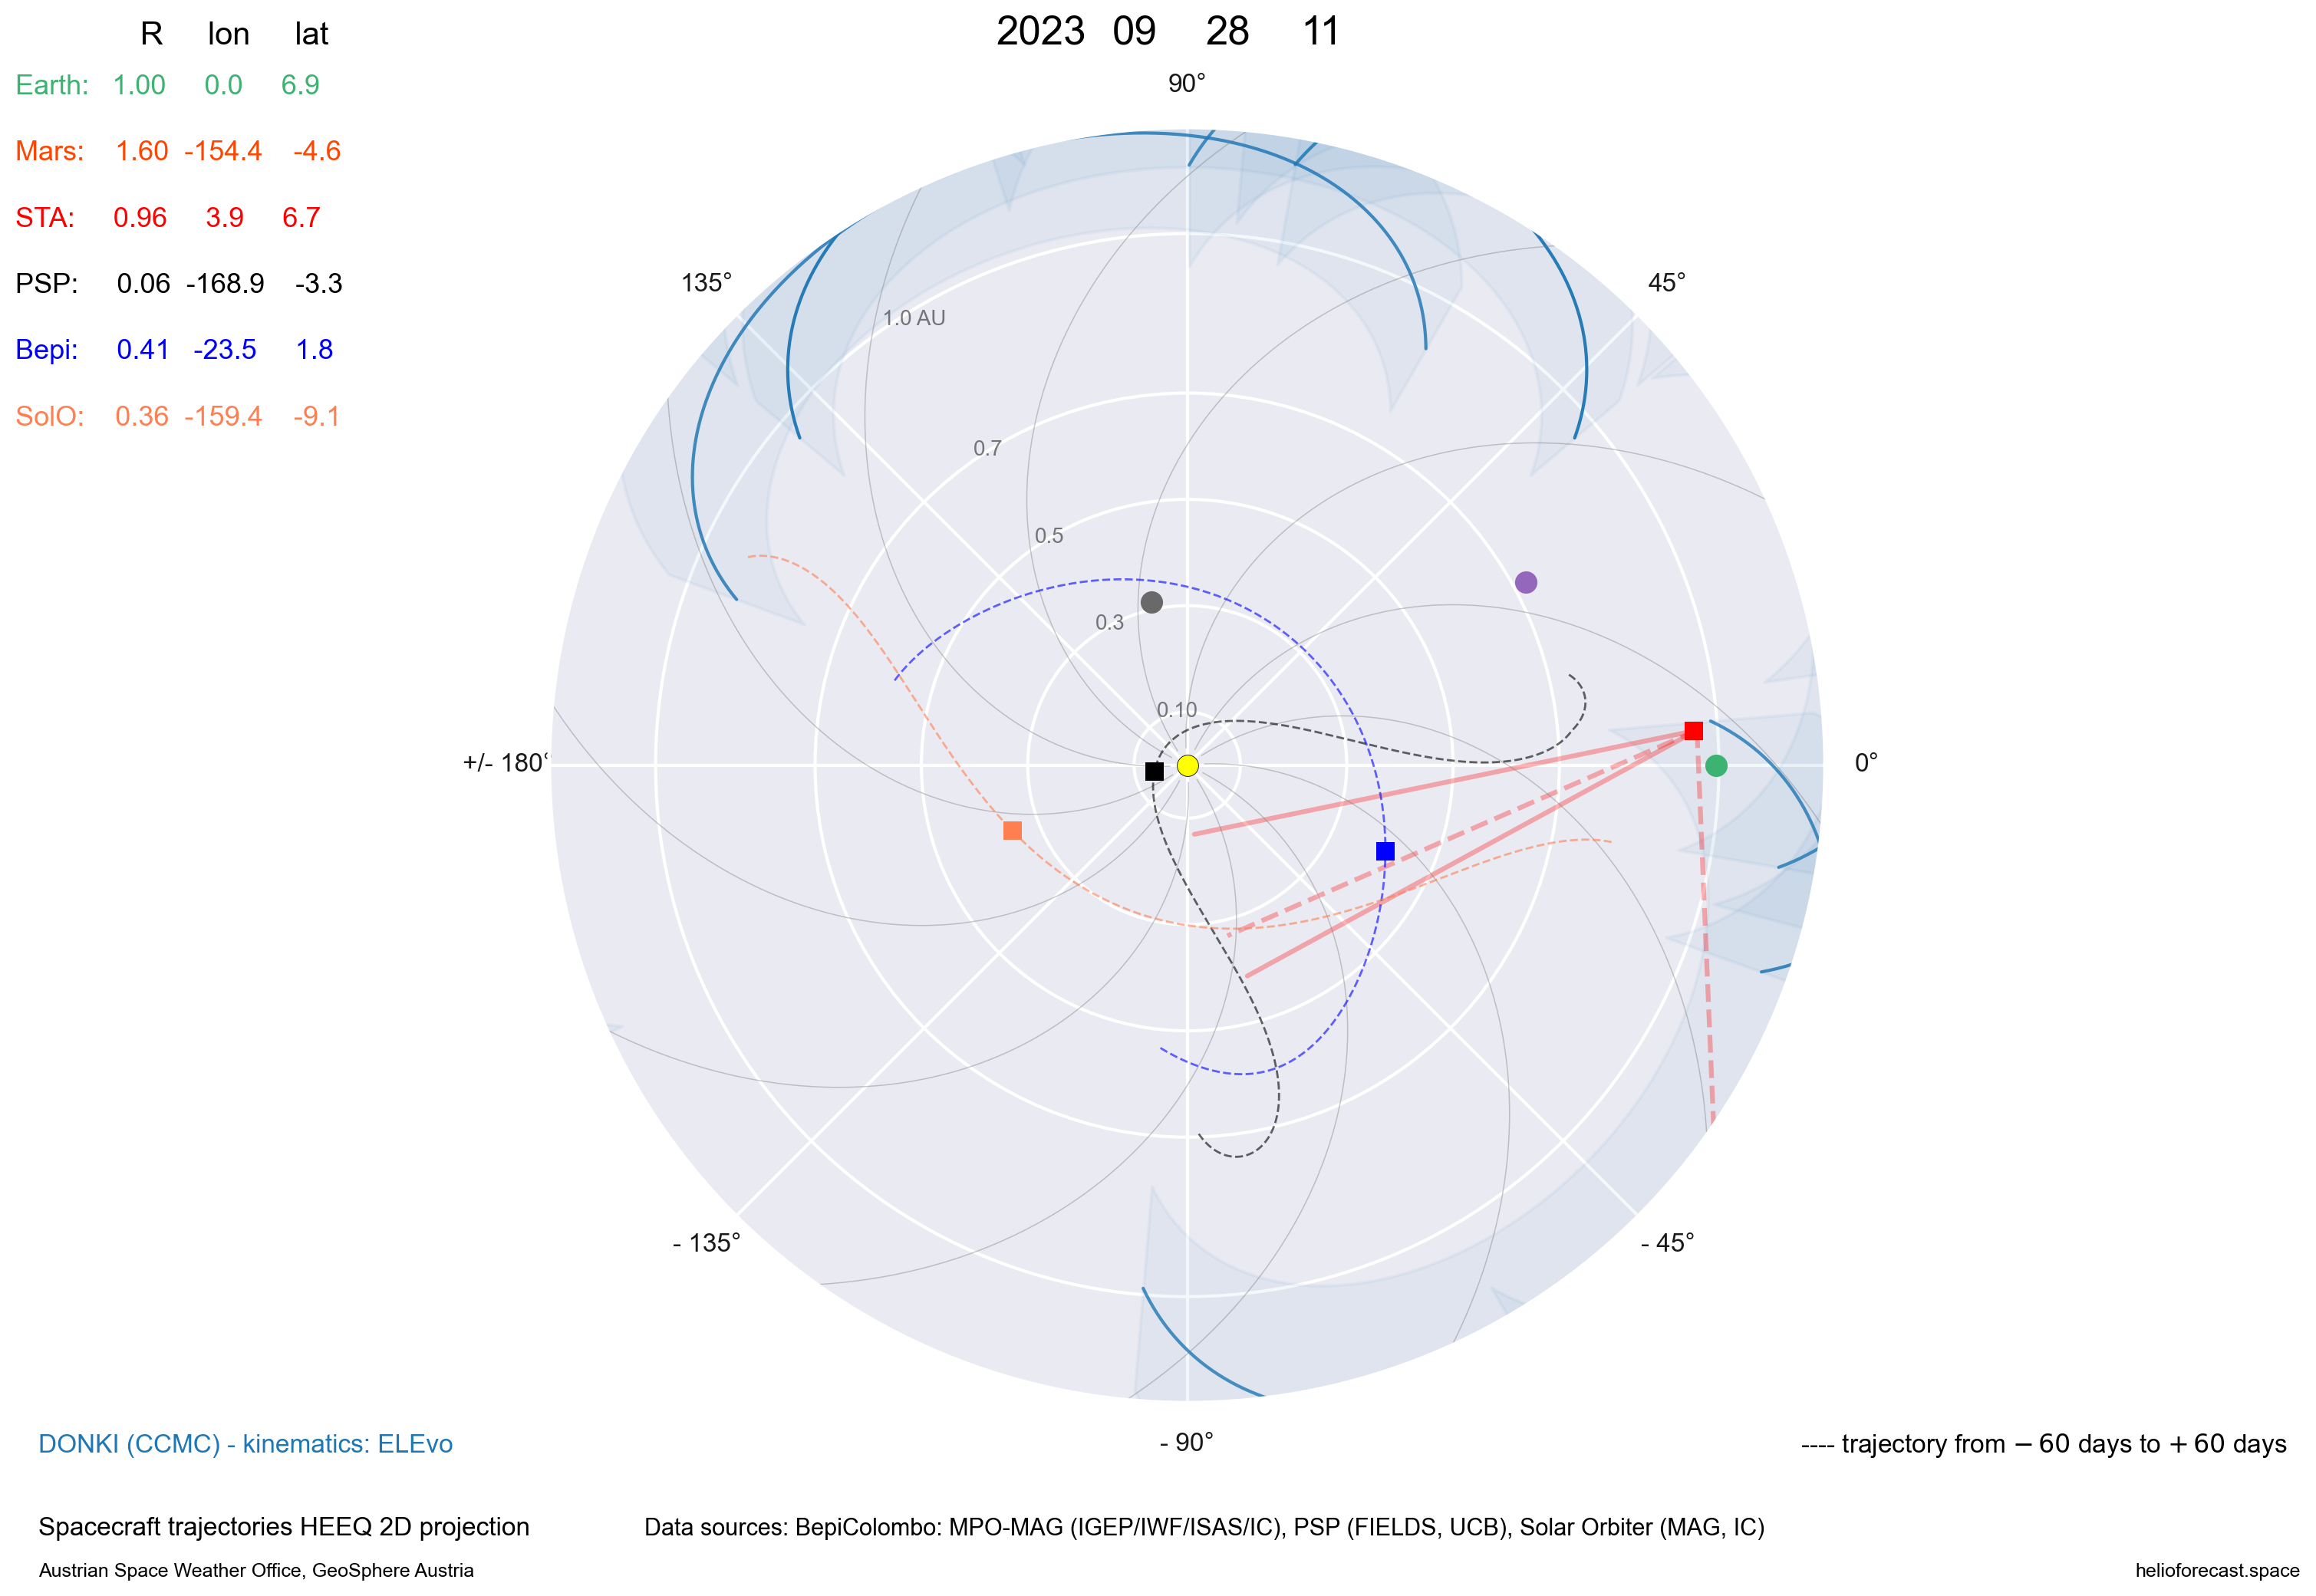

In [69]:
#for server
#matplotlib.use('Qt5Agg')

%matplotlib inline

start_time=time.time()

print()
print('make animation')

#animation start time in matplotlib format

frame_time_num=parse_time(t_start).plot_date

frame_time_num_list = [frame_time_num+k*res_in_days for k in range(k_all)]
k_today = np.where(frame_time_num_list==mdates.date2num(date_today_hour))

print(t_start)
print(frame_time_num)

sns.set_context('talk')
if not black: sns.set_style('darkgrid'),#{'grid.linestyle': ':', 'grid.color': '.35'}) 
if black: sns.set_style('white',{'grid.linestyle': ':', 'grid.color': '.35'})   

# animation settings 

fsize=13
fadeind=int(10/res_in_days)#
#fadeind=int(120/res_in_days)

symsize_planet=110
symsize_spacecraft=80

#for parker spiral   
theta=np.arange(0,np.deg2rad(180),0.01)

######################## make frames

#for debugging
#don't close plot in make_frame when testing

make_frame3(k_today[0][0]) #test animation using make_frame2 !!

#for i in np.arange(1,3,1):
#    make_frame(i)

print('done') 


## Make full movie

In [16]:

matplotlib.use('Agg')

print(k_all,' frames in total')

print()

start_time=time.time()

#number of processes depends on your machines memory; check with command line "top"
#how much memory is used by all your processesii
nr_of_processes_used=6
print('Using multiprocessing, nr of cores',multiprocessing.cpu_count(), \
      'with nr of processes used: ',nr_of_processes_used)

#run multiprocessing pool to make all movie frames, depending only on frame number

pool = mp.Pool(processes=nr_of_processes_used)
#input=[i for i in range(k_all)]
input=[i for i in np.arange(1,k_all,1)]
pool.map(make_frame, input)
#pool.close()
# pool.join()
#for i in input:
 #   make_frame2(i)

print('time in min: ',np.round((time.time()-start_time)/60))
print('plots done, frames saved in ',outputdirectory)


1873  frames in total

Using multiprocessing, nr of cores 8 with nr of processes used:  6
time in min:  6.0
plots done, frames saved in  results/website_test


Process ForkPoolWorker-8:
Process ForkPoolWorker-9:
Process ForkPoolWorker-7:
Process ForkPoolWorker-12:
Process ForkPoolWorker-10:
Process ForkPoolWorker-11:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/eva/anaconda3/envs/helio4/lib/python3.10/site-packages/multiprocess/process.py", line 314, in _bootstrap
    self.run()
  File "/Users/eva/anaconda3/envs/helio4/lib/python3.10/site-packages/multiprocess/process.py", line 314, in _bootstrap
    self.run()
  File "/Users/eva/anaconda3/envs/helio4/lib/python3.10/site-packages/multiprocess/process.py", line 314, in _bootstrap
    self.run()
  File "/Users/eva/anaconda3/envs/helio4/lib/python3.10/site-packages/multiprocess/process.py", line 314, in _bootstrap
    self.run()
  File "/Users/eva/anaconda3/envs/helio4/lib/python3.10/site-packages/multiprocess/process.

In [23]:
date_today = datetime.now().strftime('%Y-%m-%d')
os.system(ffmpeg_path+'ffmpeg -r 60 -i '+str(outputdirectory)+'/pos_anim_%05d.jpg -b 5000k \
    -r 60 '+str(animdirectory)+'/ELEvo'+date_today+'.mp4 -y -loglevel warning') 

print('movie done, saved in ',animdirectory)

Please use -b:a or -b:v, -b is ambiguous


movie done, saved in  results/website_movie_test


## 2021 April 22 event for Rodriguez paper

In [ ]:
'''
#check function makeframe2 for pdf
etime1=parse_time('2021-Apr-25 00:00').datetime
eframe1=np.where(np.array(alltimes)> etime1)[0][0]
make_frame2(eframe1)
'''


## Lineup event images

In [ ]:
'''
#load lineup catalog
url='lineups/HELIO4CAST_multipoint_v10.csv'
lineups=pd.read_csv(url)


#alltimes are the movie frame times

#time of event 1
etime1=parse_time(lineups['event_start_time'][1]).datetime
eframe1=np.where(np.array(alltimes)> etime1)[0][0]
make_frame2(eframe1)

plt.close('all')

etime2=parse_time(lineups['event_start_time'][6]).datetime
eframe2=np.where(np.array(alltimes)> etime2)[0][0]
make_frame2(eframe2)
plt.close('all')

etime4=parse_time(lineups['event_start_time'][12]).datetime
eframe4=np.where(np.array(alltimes)> etime4)[0][0]
make_frame2(eframe4)
plt.close('all')

etime4_2=parse_time(lineups['event_start_time'][11]).datetime
eframe4_2=np.where(np.array(alltimes)> etime4_2)[0][0]
make_frame2(eframe4_2)
plt.close('all')

etime12=parse_time(lineups['event_start_time'][29]).datetime
eframe12=np.where(np.array(alltimes)> etime12)[0][0]
make_frame2(eframe12)
plt.close('all')
'''







